In [3]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

dir = Path().cwd()
outdir = os.path.join(dir, 'output')
scatsFilesPath = os.path.join(dir, 'data')
finalScatsPath = os.path.join(outdir, 'processed_scats.csv')

In [4]:
def getDataSet():
    ''' Gets the dataset for this assignment
    Returns: dataset - pandas dataframe
    '''
   
    scatsFiles = os.listdir(scatsFilesPath)

    scats_data = []
    sites_data = None

    for sFile in scatsFiles:
        datasetPath = os.path.join(scatsFilesPath, sFile)
        if 'scats_volume_2020' in sFile:
            data = pd.read_csv(datasetPath, sep=",")
            
            # remove the if stament if you want to process all the files
            scats_data.append(data)
            print(sFile)
            
        elif 'sites.csv' == sFile:
            print(sFile)
            sites_data = pd.read_csv(datasetPath, sep=",", na_values='NULL')

    # merge the scats datsets
    scats_dataset = pd.concat(scats_data, ignore_index=True)

    # sites changes
    sites_data['Site'] = sites_data['SiteID'].fillna(0).astype(int)
    del sites_data['SiteID']

    #create our dataset
    dataset = pd.merge(sites_data, scats_dataset, how='left', on=['Site'])

    # scats data changes
    dataset['Site_Description'] = dataset['Site_Description_Lower']
    dataset['Region'] = dataset['Region_y']
    del dataset['Weighted_Avg']
    del dataset['Weighted_Var']
    del dataset['Weighted_Std_Dev']
    del dataset['Site_Description_Cap']
    del dataset['Site_Description_Lower']
    del dataset['Region_x']
    del dataset['Region_y']
    del dataset['Detector']

    #convert to radians for better performance 
    dataset["Lat"] = np.radians(dataset["Lat"])
    dataset["Long"] = np.radians(dataset["Long"])
    dataset = dataset[(dataset['Lat'] != 0.0) | (dataset['Long'] != 0)]

    dataset = dataset.dropna()  # delete any null values, I dont care at this point

    # we have to aggregate the detectors, this will significantly reduce the size of our dataset
    # there are about 31 detectors per site, for every hour. this makes for lots of duplicate data
    cols = {}
    for col in list(dataset.columns): 
        if col in ['Sum_Volume', 'Avg_Volume', 'Site', 'End_Time']: continue
        cols[col] = 'first'

    # group the data to aggregate the sum_volume and avg_volume
    grouped_data = dataset.groupby(['End_Time', 'Site'], as_index=False).agg({'Sum_Volume': ['sum'], 'Avg_Volume': ['sum'], **cols})
    grouped_data.columns = dataset.columns
 
    dataset = grouped_data

    return dataset

# show the first 5 columns of the dataset with the column names
dataset = getDataSet()
dataset.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/vlad/projects/dynamoDublin/backend_d-dub/ml/preprocess/scats'

In [4]:
def create_csv(dataset):
    dataset.to_csv(finalScatsPath, index=False, header=True)

# uncomment the following file to write to csv
# create_csv(dataset)

In [14]:
data = dataset[:10000]

<AxesSubplot:xlabel='Lat', ylabel='Long'>

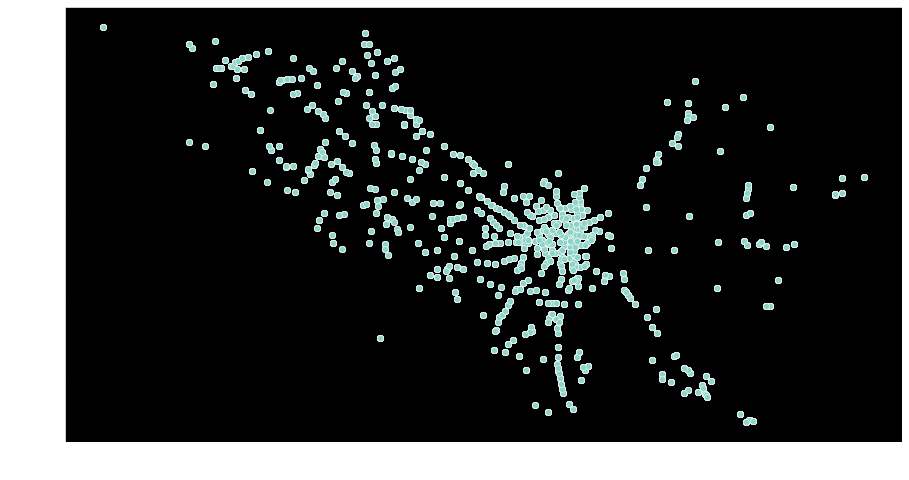

In [8]:
plt.figure(figsize = (15,8))
sns.scatterplot(data['Lat'], data['Long'])

<AxesSubplot:xlabel='Lat', ylabel='Long'>

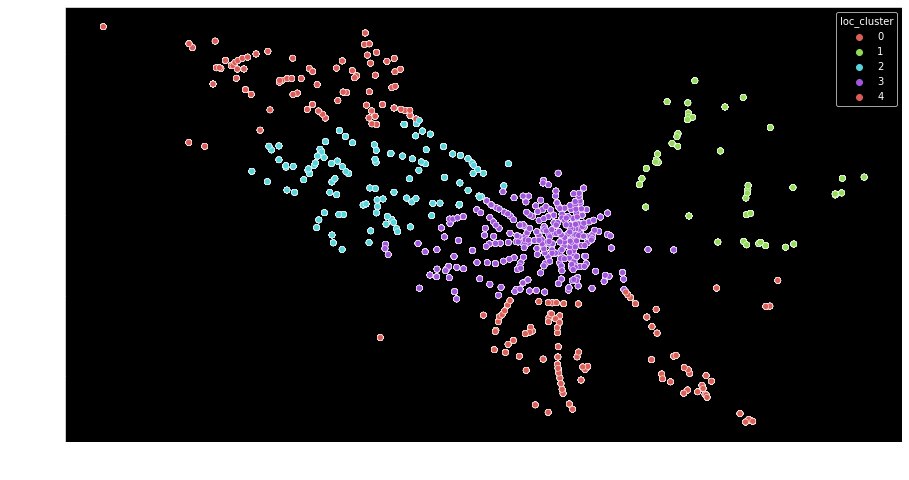

In [9]:
from sklearn.cluster import KMeans

# creates 5 clusters using k-means clustering algorithm.
scatter_data = data
kmeans = KMeans(5)
clusters = kmeans.fit_predict(scatter_data[['Lat','Long']])
scatter_data['loc_cluster'] = kmeans.predict(scatter_data[['Lat','Long']])

plt.figure(figsize = (15,8))
sns.scatterplot(scatter_data['Lat'], scatter_data['Long'], scatter_data['loc_cluster'],  palette='hls')